# Comparing Disterbution 

In [14]:
import numpy as np # array manipulation
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting


In [9]:
tmp = df[top_features +['test_group']]

In [10]:
tmp

,order_product_category_dis_all_app_types_Photo Books_cnt_1_3650,visit_frequency_time_on_site_1_365,page_category_pbpath_1_365,order_product_category_dis_all_app_types_Photo Books_cnt_1_730,order_product_category_cnt_sfly_web_all_products_cnt_1_3650,order_product_category_cnt_all_app_types_Photo Books_cnt_1_3650,order_product_category_cnt_all_app_types_all_products_cnt_1_3650,order_product_category_netrev_all_app_types_Photo Books_cnt_1_3650,order_product_category_dis_sfly_web_Photo Books_cnt_1_3650,order_product_category_netrev_all_app_types_Photo Books_cnt_1_1095,order_product_category_netrev_sfly_web_all_products_cnt_1_365,order_product_category_dis_all_app_types_Photo Books_cnt_1_1095,order_product_category_cnt_sfly_web_Photo Books_cnt_1_3650,order_product_category_dis_all_app_types_all_products_cnt_1_3650,order_product_category_dis_sfly_web_Photo Books_cnt_1_1095,funnel_all_products_1_60,visit_frequency_time_on_site_1_30,test_group
userid,,,,,,,,,,,,,,,,,,
021069620112,0,180,0,0,1,0,9,0,0,0,133,0,0,313,0,0,0,test
023062965784,44,519,2,44,12,1,12,88,44,88,272,44,1,602,44,0,0,test
024017759816,0,92,0,0,2,0,2,0,0,0,65,0,0,33,0,0,0,ctrl
000032585438,0,268,0,0,21,0,25,0,0,0,138,0,0,915,0,0,0,test
002080986575,90,5,0,0,16,3,28,24,30,0,0,0,1,1261,0,0,0,ctrl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
022097780093,0,0,0,0,0,0,2,0,0,0,0,0,0,195,0,0,0,ctrl
007043516944,252,0,0,0,2,10,125,130,0,0,0,0,0,2365,0,0,0,test
022005962313,563,93,0,0,3,2,3,606,563,606,0,563,2,567,563,0,0,test


ECDF for:  order_product_category_dis_all_app_types_Photo Books_cnt_1_3650


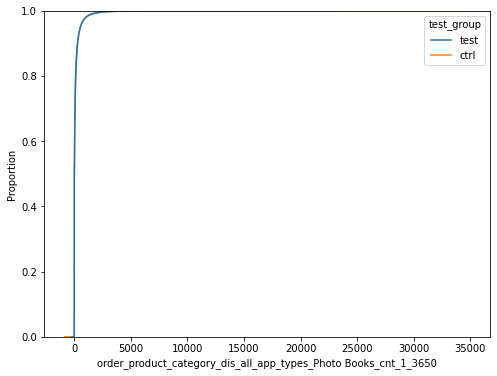

ECDF for:  visit_frequency_time_on_site_1_365


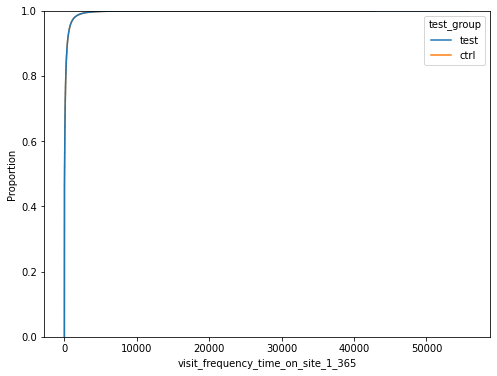

ECDF for:  page_category_pbpath_1_365


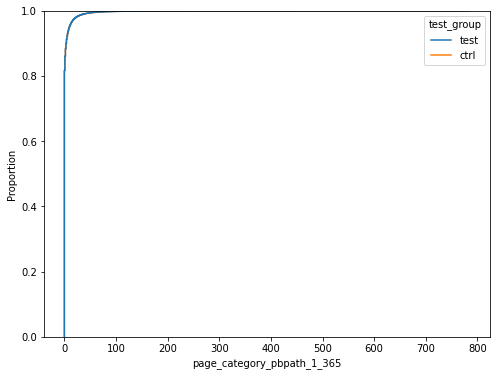

In [58]:
# method 1 of plotting ecdf
for col in tmp.columns[:3]:
    print('ECDF for: ',col)
    plt.figure(figsize=(8,6))
    sns.ecdfplot(tmp,x=col,hue="test_group" )
    plt.show()

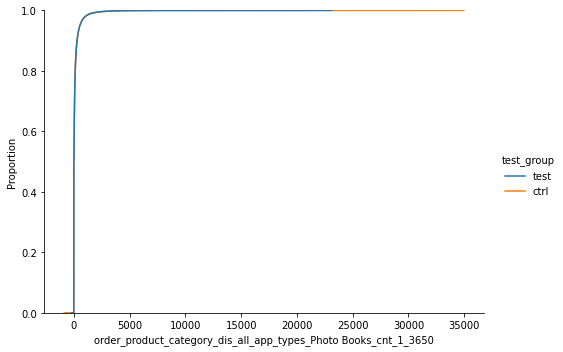

In [99]:
# method 2 of plotting ecdf
sns.displot(
  data=tmp,
  x="order_product_category_dis_all_app_types_Photo Books_cnt_1_3650",
  kind="ecdf",
  height=5,
  aspect=1.4,
  stat="proportion",hue='test_group')
plt.autoscale()

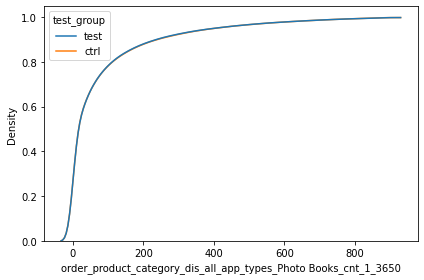

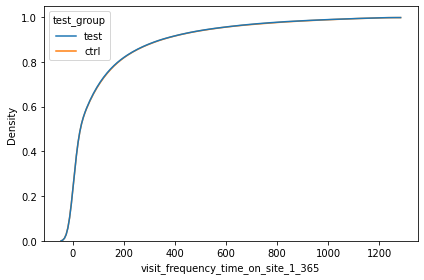

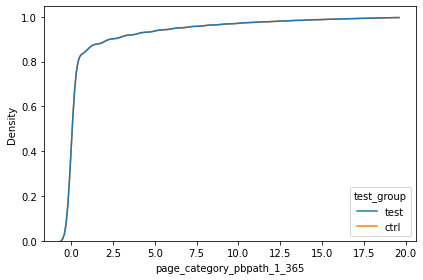

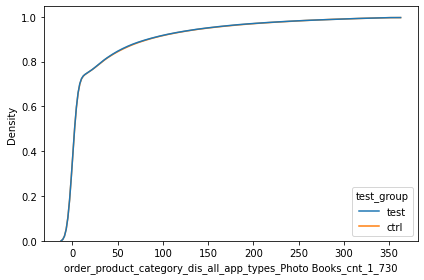

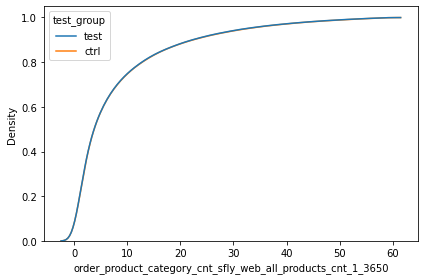

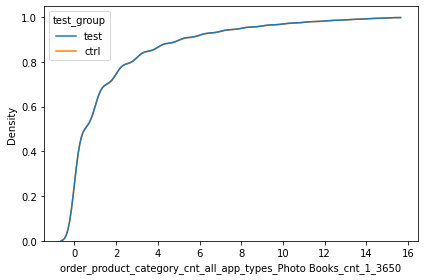

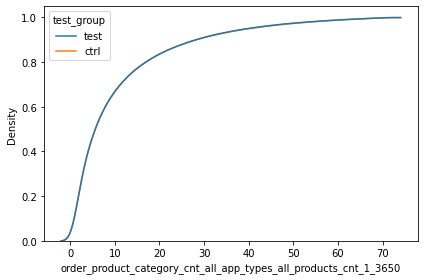

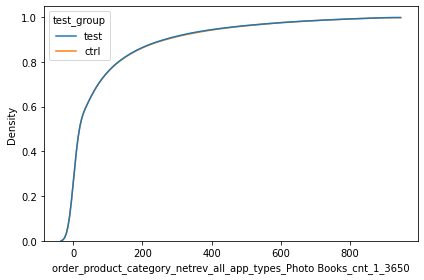

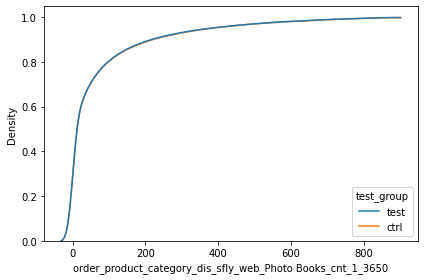

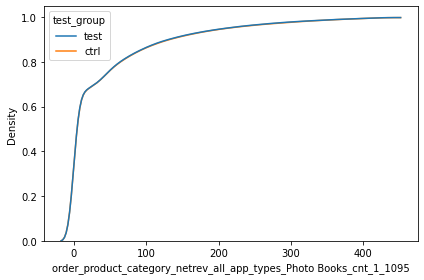

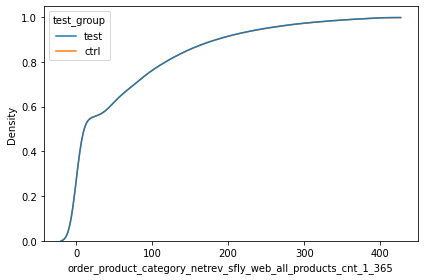

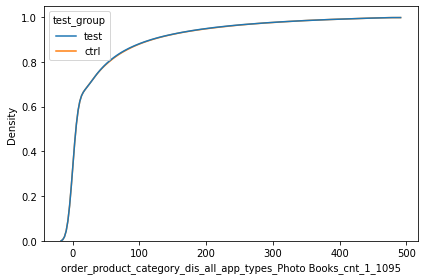

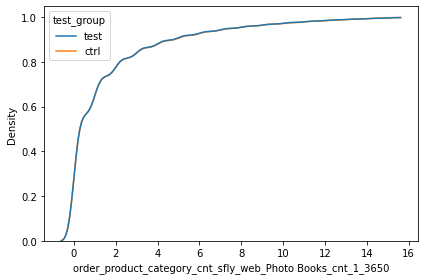

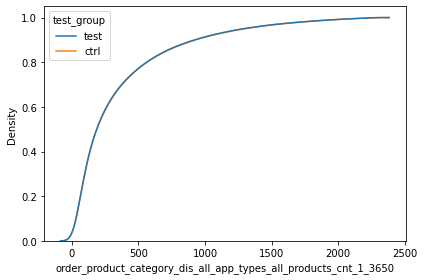

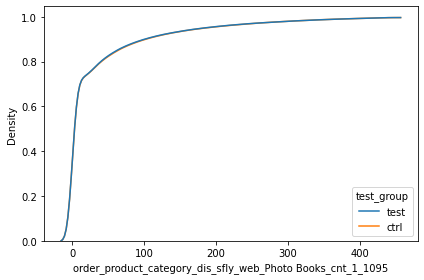

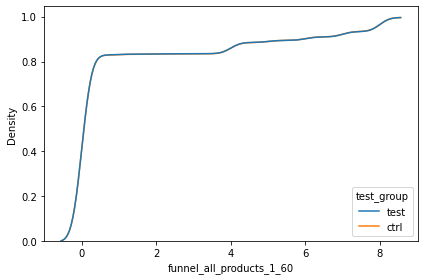

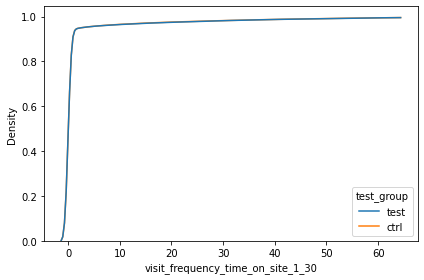

TypeError: can't multiply sequence by non-int of type 'float'

In [100]:
# plotting without outliers
for col in tmp.columns:
    s = tmp[col]
    s_adj = s[s.between(s.quantile(.025), s.quantile(.975))] # plotting middle 95%
    s_adj = tmp[['test_group']].merge(s_adj,how='left',right_index=True,left_index=True)
    s_adj.dropna(axis=0,inplace=True)

    sns.kdeplot(
        data=s_adj, x=col, hue="test_group",
        cumulative=True, common_norm=False, common_grid=True)
    plt.tight_layout()
    plt.show()

#  Kolmogorov-Smirnov Test

see KS documentation:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [96]:
from scipy import stats

for i in range(5):
    
    data1=df[top_features[i]][df.test_group=='test']
    data2=df[top_features[i]][df.test_group=='ctrl']
    print(top_features[i])
    print(stats.ks_2samp(data1, data2, alternative='two-sided', mode='auto'))
    print(' ')


order_product_category_dis_all_app_types_Photo Books_cnt_1_3650
Ks_2sampResult(statistic=0.0022023377208345574, pvalue=0.7752687524033086)
 
visit_frequency_time_on_site_1_365
Ks_2sampResult(statistic=0.002814484074190937, pvalue=0.4739679237999976)
 
page_category_pbpath_1_365
Ks_2sampResult(statistic=0.0015680075424674422, pvalue=0.9798060092859153)
 
order_product_category_dis_all_app_types_Photo Books_cnt_1_730
Ks_2sampResult(statistic=0.002057506526616293, pvalue=0.8406606234134334)
 
order_product_category_cnt_sfly_web_all_products_cnt_1_3650
Ks_2sampResult(statistic=0.0029789804967098044, pvalue=0.4015133483341315)
 


reject null hypo if P value is small (smaller than 0.05 at least)
meaning that different disterbutions

If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.

# Method A - casual ML matching 

In [ ]:
m.matched_data.head()

In [ ]:
m.matched_data.match_id.value_counts()

In [125]:
matching_df = df.copy()
matching_df['treatment_flag'] = (matching_df.test_group=='test')*1
len(top_features)

17

In [126]:
X = matching_df[top_features]
y = matching_df.treatment_flag.astype(int)

from causalml.propensity import ElasticNetPropensityModel

pm = ElasticNetPropensityModel(n_fold=5, random_state=42,n_jobs=64)
ps = pm.fit_predict(X, y)

KeyboardInterrupt: 

In [ ]:
matching_df_train['score']=ps
f=['score']+top_features

In [ ]:
from causalml.match import NearestNeighborMatch, create_table_one 

psm = NearestNeighborMatch(replace=True,
                           ratio=1,
                           random_state=42)
matched = psm.match_by_group(data=matching_df,
                             treatment_col='treatment_flag',
                             score_cols=f,
                             groupby_col='buy_flag')

In [ ]:
matched

# Method B - Mathcer

In [4]:
import pandas as pd
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from collections import Counter
from itertools import chain
import statsmodels.api as sm
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def return_timestamp():
    import time
    import datetime
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

    return st

In [5]:
df = pd.read_parquet('./df_q3_features_n_target.parquet.gzip')

In [7]:
top_features=['order_product_category_dis_all_app_types_Photo Books_cnt_1_3650',
  'visit_frequency_time_on_site_1_365',
  'page_category_pbpath_1_365',
  'order_product_category_dis_all_app_types_Photo Books_cnt_1_730',
  'order_product_category_cnt_sfly_web_all_products_cnt_1_3650',
  'order_product_category_cnt_all_app_types_Photo Books_cnt_1_3650',
  'order_product_category_cnt_all_app_types_all_products_cnt_1_3650',
  'order_product_category_netrev_all_app_types_Photo Books_cnt_1_3650',
  'order_product_category_dis_sfly_web_Photo Books_cnt_1_3650',
  'order_product_category_netrev_all_app_types_Photo Books_cnt_1_1095',
  'order_product_category_netrev_sfly_web_all_products_cnt_1_365',
  'order_product_category_dis_all_app_types_Photo Books_cnt_1_1095',
  'order_product_category_cnt_sfly_web_Photo Books_cnt_1_3650',
  'order_product_category_dis_all_app_types_all_products_cnt_1_3650',
  'order_product_category_dis_sfly_web_Photo Books_cnt_1_1095',
  'funnel_all_products_1_60',
  'visit_frequency_time_on_site_1_30']

In [68]:
# Fixed module
import numpy as np

class Matcher:
    """
    Matcher Class -- Match data for an observational study.
    Parameters
    ----------
    test : pd.DataFrame
        Data representing the test group
    control : (pd.DataFrame)
        Data representing the control group
    formula : str (optional)
        custom formula to use for logistic regression
        i.e. "Y ~ x1 + x2 + ..."
    yvar : str (optional)
        Name of dependent variable (the treatment)
    exclude : list  (optional)
        List of variables to ignore in regression/matching.
        Useful for unique idenifiers
    """

    def __init__(self, test, control, yvar, formula=None, exclude=[]):
        # configure plots for ipynb
        plt.rcParams["figure.figsize"] = (10, 5)
        # variables generated during matching
        aux_match = ['scores', 'match_id', 'weight', 'record_id']
        # assign unique indices to test and control
        t, c = [i.copy().reset_index(drop=True) for i in (test, control)]
        t = t.dropna(axis=1, how="all")
        c = c.dropna(axis=1, how="all")
        c.index += len(t)
        self.data = t.dropna(axis=1, how='all').append(c.dropna(axis=1, how='all'), sort=True)
        self.control_color = "#1F77B4"
        self.test_color = "#FF7F0E"
        self.yvar = yvar
        self.exclude = exclude + [self.yvar] + aux_match
        self.formula = formula
        self.nmodels = 1  # for now
        self.models = []
        self.swdata = None
        self.model_accuracy = []
        self.data[yvar] = self.data[yvar].astype(int)  # should be binary 0, 1
        self.xvars = [i for i in self.data.columns if i not in self.exclude and i != yvar]
        self.data = self.data.dropna(subset=self.xvars)
        self.matched_data = []
        self.xvars_escaped = [ "Q('{}')".format(x) for x in self.xvars]
        self.yvar_escaped = "Q('{}')".format(self.yvar)
        self.y, self.X = patsy.dmatrices('{} ~ {}'.format(self.yvar_escaped, '+'.join(self.xvars_escaped)),
                                         data=self.data, return_type='dataframe')
        self.xvars = [i for i in self.data.columns if i not in self.exclude]
        self.test= self.data[self.data[yvar] == True]
        self.control = self.data[self.data[yvar] == False]
        self.testn = len(self.test)
        self.controln = len(self.control)
        self.minority, self.majority = [i[1] for i in sorted(zip([self.testn, self.controln],
                                                                 [1, 0]),
                                                             key=lambda x: x[0])]
        print('Formula:\n{} ~ {}'.format(yvar, '+'.join(self.xvars)))
        print('n majority:', len(self.data[self.data[yvar] == self.majority]))
        print('n minority:', len(self.data[self.data[yvar] == self.minority]))

    def fit_scores(self, balance=True, nmodels=None):
        """
        Fits logistic regression model(s) used for
        generating propensity scores
        Parameters
        ----------
        balance : bool
            Should balanced datasets be used?
            (n_control == n_test)
        nmodels : int
            How many models should be fit?
            Score becomes the average of the <nmodels> models if nmodels > 1
        Returns
        -------
        None
        """
        # reset models if refitting
        if len(self.models) > 0:
            self.models = []
        if len(self.model_accuracy) > 0:
            self.model_accuracy = []
        if not self.formula:
            # use all columns in the model
            self.xvars_escaped = [ "Q('{}')".format(x) for x in self.xvars]
            self.yvar_escaped = "Q('{}')".format(self.yvar)
            self.formula = '{} ~ {}'.format(self.yvar_escaped, '+'.join(self.xvars_escaped))
        if balance:
            if nmodels is None:
                # fit multiple models based on imbalance severity (rounded up to nearest tenth)
                minor, major = [self.data[self.data[self.yvar] == i] for i in (self.minority,
                                                                               self.majority)]
                nmodels = int(np.ceil((len(major) / len(minor)) / 10) * 10)
            self.nmodels = nmodels
            i = 0
            errors = 0
            while i < nmodels and errors < 5:
                progress(i+1, nmodels, prestr="Fitting Models on Balanced Samples")
                # sample from majority to create balance dataset
                df = self.balanced_sample()
                df = pd.concat([drop_static_cols(df[df[self.yvar] == 1], yvar=self.yvar),
                                drop_static_cols(df[df[self.yvar] == 0], yvar=self.yvar)],
                               sort=True)
                y_samp, X_samp = patsy.dmatrices(self.formula, data=df, return_type='dataframe')
                X_samp.drop(self.yvar, axis=1, errors='ignore', inplace=True)
                glm = GLM(y_samp, X_samp, family=sm.families.Binomial())

                try:
                    res = glm.fit()
                    self.model_accuracy.append(self._scores_to_accuracy(res, X_samp, y_samp))
                    self.models.append(res)
                    i = i + 1
                except Exception as e:
                    errors = errors + 1 # to avoid infinite loop for misspecified matrix
                    print('Error: {}'.format(e))
            print("\nAverage Accuracy:", "{}%".
                  format(round(np.mean(self.model_accuracy) * 100, 2)))
        else:
            # ignore any imbalance and fit one model
            print('Fitting 1 (Unbalanced) Model...')
            glm = GLM(self.y, self.X, family=sm.families.Binomial())
            res = glm.fit()
            self.model_accuracy.append(self._scores_to_accuracy(res, self.X, self.y))
            self.models.append(res)
            print("\nAccuracy", round(np.mean(self.model_accuracy[0]) * 100, 2))


    def predict_scores(self):
        """
        Predict Propensity scores for each observation.
        Adds a "scores" columns to self.data
        Returns
        -------
        None
        """
        scores = np.zeros(len(self.X))
        for i in range(self.nmodels):
            
            print('model number: ',i)
            
            m = self.models[i]
            scores += m.predict(self.X[m.params.index])
        self.data['scores'] = scores/self.nmodels

    def match(self, threshold=0.001, nmatches=1, method='min', max_rand=10):
        """
        Finds suitable match(es) for each record in the minority
        dataset, if one exists. Records are exlcuded from the final
        matched dataset if there are no suitable matches.
        self.matched_data contains the matched dataset once this
        method is called
        Parameters
        ----------
        threshold : float
            threshold for fuzzy matching matching
            i.e. |score_x - score_y| >= theshold
        nmatches : int
            How majority profiles should be matched
            (at most) to minority profiles
        method : str
            Strategy for when multiple majority profiles
            are suitable matches for a single minority profile
            "random" - choose randomly (fast, good for testing)
            "min" - choose the profile with the closest score
        max_rand : int
            max number of profiles to consider when using random tie-breaks
        Returns
        -------
        None
        """
        if 'scores' not in self.data.columns:
            print("Propensity Scores have not been calculated. Using defaults...")
            self.fit_scores()
            self.predict_scores()
        test_scores = self.data[self.data[self.yvar]==True][['scores']]
        ctrl_scores = self.data[self.data[self.yvar]==False][['scores']]
        result, match_ids = [], []
        for i in range(len(test_scores)):
#             uf.progress(i+1, len(test_scores), 'Matching Control to Test...')
            match_id = i
            score = test_scores.iloc[i]
            if method == 'random':
                bool_match = abs(ctrl_scores - score) <= threshold
                matches = ctrl_scores.loc[bool_match[bool_match.scores].index]
            elif method == 'min':
                matches = abs(ctrl_scores - score).sort_values('scores').head(nmatches)
            else:
                raise(AssertionError, "Invalid method parameter, use ('random', 'min')")
            if len(matches) == 0:
                continue
            # randomly choose nmatches indices, if len(matches) > nmatches
            select = nmatches if method != 'random' else np.random.choice(range(1, max_rand+1), 1)
            chosen = np.random.choice(matches.index, min(select, nmatches), replace=False)
            result.extend([test_scores.index[i]] + list(chosen))
            match_ids.extend([i] * (len(chosen)+1))
            
            if i%1000 ==0 : 
                print(return_timestamp(),i,'out of', len(test_scores),'Matching Control to Test...')
            
        self.matched_data = self.data.loc[result]
        self.matched_data['match_id'] = match_ids
        self.matched_data['record_id'] = self.matched_data.index

    def select_from_design(self, cols):
        d = pd.DataFrame()
        for c in cols:
            d = pd.concat([d, self.X.select(lambda x: x.startswith(c), axis=1)], axis=1, sort=True)
        return d

    def balanced_sample(self, data=None):
        if not data:
            data=self.data
        minor, major =  data[data[self.yvar] == self.minority], \
                        data[data[self.yvar] == self.majority]
        return major.sample(len(minor)).append(minor, sort=True).dropna()

    def plot_scores(self):
        """
        Plots the distribution of propensity scores before matching between
        our test and control groups
        """
        assert 'scores' in self.data.columns, \
            "Propensity scores haven't been calculated, use Matcher.predict_scores()"
        sns.distplot(self.data[self.data[self.yvar]==0].scores, label='Control')
        sns.distplot(self.data[self.data[self.yvar]==1].scores, label='Test')
        plt.legend(loc='upper right')
        plt.xlim((0, 1))
        plt.title("Propensity Scores Before Matching")
        plt.ylabel("Percentage (%)")
        plt.xlabel("Scores")

    def prop_test(self, col):
        """
        Performs a Chi-Square test of independence on <col>
        See stats.chi2_contingency()
        Parameters
        ----------
        col : str
            Name of column on which the test should be performed
        Returns
        ______
        dict
            {'var': <col>,
             'before': <pvalue before matching>,
             'after': <pvalue after matching>}
        """
        if not is_continuous(col, self.X) and col not in self.exclude:
            pval_before = round(stats.chi2_contingency(self.prep_prop_test(self.data,
                                                                           col))[1], 6)
            pval_after = round(stats.chi2_contingency(self.prep_prop_test(self.matched_data,
                                                                          col))[1], 6)
            return {'var':col, 'before':pval_before, 'after':pval_after}
        else:
            print("{} is a continuous variable".format(col))

    def compare_continuous(self, save=False, return_table=False):
        """
        Plots the ECDFs for continuous features before and
        after matching. Each chart title contains test results
        and statistics to summarize how similar the two distributions
        are (we want them to be close after matching).
        Tests performed:
        Kolmogorov-Smirnov Goodness of fit Test (KS-test)
            This test statistic is calculated on 1000
            permuted samples of the data, generating
            an imperical p-value.  See pymatch.functions.ks_boot()
            This is an adaptation of the ks.boot() method in
            the R "Matching" package
            https://www.rdocumentation.org/packages/Matching/versions/4.9-2/topics/ks.boot
        Chi-Square Distance:
            Similarly this distance metric is calculated on
            1000 permuted samples.
            See pymatch.functions.grouped_permutation_test()
        Other included Stats:
        Standarized mean and median differences
        How many standard deviations away are the mean/median
        between our groups before and after matching
        i.e. abs(mean(control) - mean(test)) / std(control.union(test))
        Parameters
        ----------
        return_table : bool
            Should the function a table with tests and statistics?
        Returns
        -------
        pd.DataFrame (optional)
            Table of before/after statistics if return_table == True
        """
        test_results = []
        for col in self.matched_data.columns:
            if is_continuous(col, self.X) and col not in self.exclude:
                print(col)
                print(self.X)
                # organize data
                trb, cob = self.test[col], self.control[col]
                tra = self.matched_data[self.matched_data[self.yvar]==True][col]
                coa = self.matched_data[self.matched_data[self.yvar]==False][col]
                xtb, xcb = ECDF(trb), ECDF(cob)
                xta, xca = ECDF(tra),ECDF(coa)

                # before/after stats
                std_diff_med_before, std_diff_mean_before = std_diff(trb, cob)
                std_diff_med_after, std_diff_mean_after = std_diff(tra, coa)
                pb, truthb = grouped_permutation_test(chi2_distance, trb, cob)
                pa, trutha = grouped_permutation_test(chi2_distance, tra, coa)
                ksb = round(ks_boot(trb, cob, nboots=1000), 6)
                ksa = round(ks_boot(tra, coa, nboots=1000), 6)

                # plotting
                f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))
                ax1.plot(xcb.x, xcb.y, label='Control', color=self.control_color)
                ax1.plot(xtb.x, xtb.y, label='Test', color=self.test_color)
                ax1.plot(xcb.x, xcb.y, label='Control', color=self.control_color)
                ax1.plot(xtb.x, xtb.y, label='Test', color=self.test_color)

                title_str = '''
                ECDF for {} {} Matching
                KS p-value: {}
                Grouped Perm p-value: {}
                Std. Median Difference: {}
                Std. Mean Difference: {}
                '''
                ax1.set_title(title_str.format(col, "before", ksb, pb,
                                               std_diff_med_before, std_diff_mean_before))
                ax2.plot(xca.x, xca.y, label='Control')
                ax2.plot(xta.x, xta.y, label='Test')
                ax2.set_title(title_str.format(col, "after", ksa, pa,
                                               std_diff_med_after, std_diff_mean_after))
                ax2.legend(loc="lower right")
                plt.xlim((0, np.percentile(xta.x, 99)))

                test_results.append({
                        "var": col,
                        "ks_before": ksb,
                        "ks_after": ksa,
                        "grouped_chisqr_before": pb,
                        "grouped_chisqr_after": pa,
                        "std_median_diff_before": std_diff_med_before,
                        "std_median_diff_after": std_diff_med_after,
                        "std_mean_diff_before": std_diff_mean_before,
                        "std_mean_diff_after": std_diff_mean_after
                    })

        var_order = [
                    "var",
                    "ks_before",
                    "ks_after",
                    "grouped_chisqr_before",
                    "grouped_chisqr_after",
                    "std_median_diff_before",
                    "std_median_diff_after",
                    "std_mean_diff_before",
                    "std_mean_diff_after"
                ]

        return pd.DataFrame(test_results)[var_order] if return_table else None

    def compare_categorical(self, return_table=False):
        """
        Plots the proportional differences of each enumerated
        discete column for test and control.
        i.e. <prop_test_that_have_x>  - <prop_control_that_have_x>
        Each chart title contains the results from a
        Chi-Square Test of Independence before and after
        matching.
        See pymatch.prop_test()
        Parameters
        ----------
        return_table : bool
            Should the function return a table with
            test results?
        Return
        ------
        pd.DataFrame() (optional)
            Table with the p-values of the Chi-Square contingency test
            for each discrete column before and after matching
        """
        def prep_plot(data, var, colname):
            t, c = data[data[self.yvar] == 1], data[data[self.yvar] == 0]
            # dummy var for counting
            dummy = [i for i in t.columns if i not in \
                      (var, "match_id", "record_id", "weight")][0]
            countt = t[[var, dummy]].groupby(var).count() / len(t)
            countc = c[[var, dummy]].groupby(var).count() / len(c)
            ret = (countt-countc).dropna()
            ret.columns = [colname]
            return ret

        title_str = '''
        Proportional Difference (test-control) for {} Before and After Matching
        Chi-Square Test for Independence p-value before | after:
        {} | {}
        '''
        test_results = []
        for col in self.matched_data.columns:
            if not is_continuous(col, self.X) and col not in self.exclude:
                dbefore = prep_plot(self.data, col, colname="before")
                dafter = prep_plot(self.matched_data, col, colname="after")
                df = dbefore.join(dafter)
                test_results_i = self.prop_test(col)
                test_results.append(test_results_i)

                # plotting
                df.plot.bar(alpha=.8)
                plt.title(title_str.format(col, test_results_i["before"],
                                           test_results_i["after"]))
                lim = max(.09, abs(df).max().max()) + .01
                plt.ylim((-lim, lim))
        return pd.DataFrame(test_results)[['var', 'before', 'after']] if return_table else None

    def prep_prop_test(self, data, var):
        """
        Helper method for running chi-square contingency tests
        Balances the counts of discrete variables with our groups
        so that missing levels are replaced with 0.
        i.e. if the test group has no records with x as a field
        for a given column, make sure the count for x is 0
        and not missing.
        Parameters
        ----------
        data : pd.DataFrame()
            Data to use for counting
        var : str
            Column to use within data
        Returns
        -------
        list
            A table (list of lists) of counts for all enumerated field within <var>
            for test and control groups.
        """
        counts = data.groupby([var, self.yvar]).count().reset_index()
        table = []
        for t in (0, 1):
            os_counts = counts[counts[self.yvar] ==t]\
                                     .sort_values(var)
            cdict = {}
            for row in os_counts.iterrows():
                row = row[1]
                cdict[row[var]] = row[2]
            table.append(cdict)
        # fill empty keys as 0
        all_keys = set(chain.from_iterable(table))
        for d in table:
            d.update((k, 0) for k in all_keys if k not in d)
        ctable = [[i[k] for k in sorted(all_keys)] for i in table]
        return ctable

    def prop_retained(self):
        """
        Returns the proportion of data retained after matching
        """
        return len(self.matched_data[self.matched_data[self.yvar] == self.minority]) * 1.0 / \
               len(self.data[self.data[self.yvar] == self.minority])

    def tune_threshold(self, method, nmatches=1, rng=np.arange(0, .001, .0001)):
        """
        Matches data over a grid to optimize threshold value and plots results.
        Parameters
        ----------
        method : str
            Method used for matching (use "random" for this method)
        nmatches : int
            Max number of matches per record. See pymatch.match()
        rng: : list / np.array()
            Grid of threshold values
        Returns
        -------
        None
        """
        results = []
        for i in rng:
            self.match(method=method, nmatches=nmatches, threshold=i)
            results.append(self.prop_retained())
        plt.plot(rng, results)
        plt.title("Proportion of Data retained for grid of threshold values")
        plt.ylabel("Proportion Retained")
        plt.xlabel("Threshold")
        plt.xticks(rng)

    def record_frequency(self):
        """
        Calculates the frequency of specifi records in
        the matched dataset
        Returns
        -------
        pd.DataFrame()
            Frequency table of the number records
            matched once, twice, ..., etc.
        """
        freqs = self.matched_data.groupby("record_id")\
                    .count().groupby("match_id").count()\
                    [["scores"]].reset_index()
        freqs.columns = ["freq", "n_records"]
        return freqs

    def assign_weight_vector(self):
        record_freqs = self.matched_data.groupby("record_id")\
                           .count()[['match_id']].reset_index()
        record_freqs.columns = ["record_id", "weight"]
        fm = record_freqs.merge(self.matched_data, on="record_id")
        fm['weight'] = 1/fm['weight']
        self.matched_data = fm

    @staticmethod
    def _scores_to_accuracy(m, X, y):
        preds = [[1.0 if i >= .5 else 0.0 for i in m.predict(X)]]
#         return (y == preds).sum() * 1.0 / len(y)
        return (y.to_numpy().T == preds).sum() * 1.0 / len(y)

In [35]:
import sys
import numpy as np


def drop_static_cols(df, yvar, cols=None):
    if not cols:
        cols = list(df.columns)
    # will be static for both groups
    cols.pop(cols.index(yvar))
    for col in df[cols]:
        n_unique = len(np.unique(df[col]))
        if n_unique == 1:
            df.drop(col, axis=1, inplace=True)
            sys.stdout.write('\rStatic column dropped: {}'.format(col))
    return df
  
  
def ks_boot(tr, co, nboots=1000):
    nx = len(tr)
    w = np.concatenate((tr, co))
    obs = len(w)
    cutp = nx
    bbcount = 0
    ss = []
    fs_ks, _ = stats.ks_2samp(tr, co)
    for bb in range(nboots):
        sw = np.random.choice(w, obs, replace=True)
        x1tmp = sw[:cutp]
        x2tmp = sw[cutp:]
        s_ks, _ = stats.ks_2samp(x1tmp, x2tmp)
        ss.append(s_ks)
        if s_ks >= fs_ks:
            bbcount += 1
    ks_boot_pval = bbcount * 1.0 / nboots
    return ks_boot_pval


def _chi2_distance(tb, cb):
    dist = 0
    for b in set(np.union1d(list(tb.keys()), list(cb.keys()))):
        if b not in tb:
            tb[b] = 0
        if b not in cb:
            cb[b] = 0
        xi, yi = tb[b], cb[b]
        dist += ((xi - yi) ** 2) * 1.0 / (xi + yi)
    return dist * 1.0 / 2


def chi2_distance(t, c):
    tb, cb, bins = which_bin_hist(t, c)
    tb, cb = bin_hist(tb, cb, bins)
    return _chi2_distance(tb,cb)


def which_bin_hist(t, c):
    comb = np.concatenate((t, c))
    bins = np.arange(np.percentile(comb, 99), step=10)
    t_binned = np.digitize(t, bins)
    c_binned = np.digitize(c, bins)
    return t_binned, c_binned, bins


def bin_hist(t, c, bins):
    tc, cc = Counter(t), Counter(c)

    def idx_to_value(d, bins):
        result = {}
        for k, v, in d.items():
            result[int(bins[k-1])] = v
        return result

    return idx_to_value(tc, bins), idx_to_value(cc, bins)


def grouped_permutation_test(f, t, c, n_samples=1000):
    truth = f(t, c)
    comb = np.concatenate((t, c))
    times_geq=0
    samp_arr = []
    for i in range(n_samples):
        tn = len(t)
        combs = comb[:]
        np.random.shuffle(combs)
        tt = combs[:tn]
        cc = combs[tn:]
        sample_truth = f(np.array(tt), np.array(cc))
        if sample_truth >= truth:
            times_geq += 1
        samp_arr.append(sample_truth)
    return (times_geq * 1.0) / n_samples, truth


def std_diff(a, b):
    sd = np.std(a.append(b))
    med = (np.median(a) - np.median(b)) * 1.0 / sd
    mean = (np.mean(a) - np.mean(b)) * 1.0 / sd
    return med, mean


def progress(i, n, prestr=''):
    sys.stdout.write('\r{}: {}\{}'.format(prestr, i, n))


def is_continuous(colname, dmatrix):
    """
    Check if the colname was treated as continuous in the patsy.dmatrix
    Would look like colname[<factor_value>] otherwise
    """
    return (colname in dmatrix.columns) or ("Q('{}')".format(colname) in dmatrix.columns)


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [45]:
df['treatment_flag']= (df.test_group=='test')*1

ctrl=df[top_features + ['treatment_flag']][model_train.test_group == 'ctrl']
test =df[top_features + ['treatment_flag']][model_train.test_group == 'test']

### Start matching 

In [69]:
m = Matcher(test,ctrl,yvar="treatment_flag", exclude=[],)

Formula:
treatment_flag ~ funnel_all_products_1_60+order_product_category_cnt_all_app_types_Photo Books_cnt_1_3650+order_product_category_cnt_all_app_types_all_products_cnt_1_3650+order_product_category_cnt_sfly_web_Photo Books_cnt_1_3650+order_product_category_cnt_sfly_web_all_products_cnt_1_3650+order_product_category_dis_all_app_types_Photo Books_cnt_1_1095+order_product_category_dis_all_app_types_Photo Books_cnt_1_3650+order_product_category_dis_all_app_types_Photo Books_cnt_1_730+order_product_category_dis_all_app_types_all_products_cnt_1_3650+order_product_category_dis_sfly_web_Photo Books_cnt_1_1095+order_product_category_dis_sfly_web_Photo Books_cnt_1_3650+order_product_category_netrev_all_app_types_Photo Books_cnt_1_1095+order_product_category_netrev_all_app_types_Photo Books_cnt_1_3650+order_product_category_netrev_sfly_web_all_products_cnt_1_365+page_category_pbpath_1_365+visit_frequency_time_on_site_1_30+visit_frequency_time_on_site_1_365
n majority: 100236
n minority: 9976

In [70]:
import numpy as np
np.random.seed(20170925)

m.fit_scores(balance=True, nmodels=150) # can play with number of models between 100 - 300

Fitting Models on Balanced Samples: 150\150
Average Accuracy: 50.24%


In [71]:
m.predict_scores()

model number:  0
model number:  1
model number:  2
model number:  3
model number:  4
model number:  5
model number:  6
model number:  7
model number:  8
model number:  9
model number:  10
model number:  11
model number:  12
model number:  13
model number:  14
model number:  15
model number:  16
model number:  17
model number:  18
model number:  19
model number:  20
model number:  21
model number:  22
model number:  23
model number:  24
model number:  25
model number:  26
model number:  27
model number:  28
model number:  29
model number:  30
model number:  31
model number:  32
model number:  33
model number:  34
model number:  35
model number:  36
model number:  37
model number:  38
model number:  39
model number:  40
model number:  41
model number:  42
model number:  43
model number:  44
model number:  45
model number:  46
model number:  47
model number:  48
model number:  49
model number:  50
model number:  51
model number:  52
model number:  53
model number:  54
model number:  55
mo

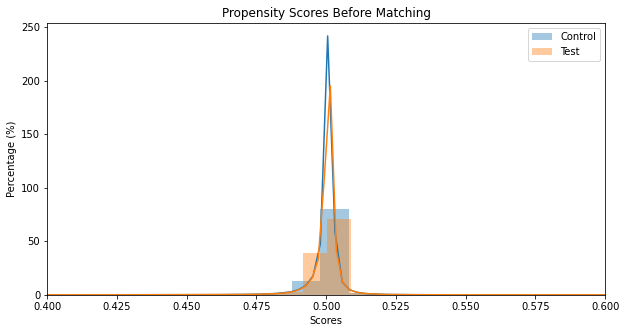

In [72]:
# scores prior to matching 
m.plot_scores()

In [73]:
# this takes a while
m.tune_threshold(method='random')

In [74]:
m.match(method="min", nmatches=1, threshold=0.0001)

2021-08-08 12:22:13 1 out of 100236 Matching Control to Test...
2021-08-08 12:22:14 101 out of 100236 Matching Control to Test...
2021-08-08 12:22:15 201 out of 100236 Matching Control to Test...
2021-08-08 12:22:16 301 out of 100236 Matching Control to Test...
2021-08-08 12:22:18 401 out of 100236 Matching Control to Test...
2021-08-08 12:22:19 501 out of 100236 Matching Control to Test...
2021-08-08 12:22:20 601 out of 100236 Matching Control to Test...
2021-08-08 12:22:21 701 out of 100236 Matching Control to Test...
2021-08-08 12:22:22 801 out of 100236 Matching Control to Test...
2021-08-08 12:22:24 901 out of 100236 Matching Control to Test...
2021-08-08 12:22:25 1001 out of 100236 Matching Control to Test...
2021-08-08 12:22:26 1101 out of 100236 Matching Control to Test...
2021-08-08 12:22:27 1201 out of 100236 Matching Control to Test...
2021-08-08 12:22:28 1301 out of 100236 Matching Control to Test...
2021-08-08 12:22:30 1401 out of 100236 Matching Control to Test...
2021-08

In [77]:
m.record_frequency()

,freq,n_records
0,1,125854
1,2,12793
2,3,5873
3,4,2533
4,5,1090
...,...,...
74,118,1
75,139,1
76,142,1
77,160,1


In [85]:
# def assign_weight_vector(self):
# record_freqs = m.matched_data.groupby("record_id")\
#                    .count()[['match_id']].reset_index()
# record_freqs.columns = ["record_id", "weight"]
# fm = record_freqs.merge(m.matched_data, on="record_id")
# fm['weight_x'] = 1/fm['weight_x']
# m.matched_data = fm

In [86]:
m.matched_data

,record_id,weight_x,weight_y,funnel_all_products_1_60,order_product_category_cnt_all_app_types_Photo Books_cnt_1_3650,order_product_category_cnt_all_app_types_all_products_cnt_1_3650,order_product_category_cnt_sfly_web_Photo Books_cnt_1_3650,order_product_category_cnt_sfly_web_all_products_cnt_1_3650,order_product_category_dis_all_app_types_Photo Books_cnt_1_1095,order_product_category_dis_all_app_types_Photo Books_cnt_1_3650,...,order_product_category_dis_sfly_web_Photo Books_cnt_1_3650,order_product_category_netrev_all_app_types_Photo Books_cnt_1_1095,order_product_category_netrev_all_app_types_Photo Books_cnt_1_3650,order_product_category_netrev_sfly_web_all_products_cnt_1_365,page_category_pbpath_1_365,treatment_flag,visit_frequency_time_on_site_1_30,visit_frequency_time_on_site_1_365,scores,match_id
0,0,1.0,1.0,0,1,2,1,2,150,150,...,150,150,150,40,0,1,0,0,0.502482,0
1,1,1.0,1.0,0,1,1,1,1,41,41,...,41,62,62,0,0,1,0,0,0.502300,1
2,2,1.0,1.0,0,0,39,0,13,0,0,...,0,0,0,0,0,1,0,0,0.493350,2
3,3,1.0,1.0,0,2,8,2,8,0,135,...,135,0,48,0,0,1,0,28,0.499239,3
4,4,1.0,1.0,0,0,109,0,109,0,0,...,0,0,0,370,0,1,0,318,0.475972,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200467,199999,0.2,0.2,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0.500794,26918
200468,199999,0.2,0.2,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0.500794,59684
200469,199999,0.2,0.2,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0.500794,66142
200470,199999,0.2,0.2,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0.500794,74205


In [80]:
m.assign_weight_vector()

KeyError: 'weight'

In [87]:
m.matched_data.sort_values("match_id").head(6)


,record_id,weight_x,weight_y,funnel_all_products_1_60,order_product_category_cnt_all_app_types_Photo Books_cnt_1_3650,order_product_category_cnt_all_app_types_all_products_cnt_1_3650,order_product_category_cnt_sfly_web_Photo Books_cnt_1_3650,order_product_category_cnt_sfly_web_all_products_cnt_1_3650,order_product_category_dis_all_app_types_Photo Books_cnt_1_1095,order_product_category_dis_all_app_types_Photo Books_cnt_1_3650,...,order_product_category_dis_sfly_web_Photo Books_cnt_1_3650,order_product_category_netrev_all_app_types_Photo Books_cnt_1_1095,order_product_category_netrev_all_app_types_Photo Books_cnt_1_3650,order_product_category_netrev_sfly_web_all_products_cnt_1_365,page_category_pbpath_1_365,treatment_flag,visit_frequency_time_on_site_1_30,visit_frequency_time_on_site_1_365,scores,match_id
0,0,1.000000,1.000000,0,1,2,1,2,150,150,...,150,150,150,40,0,1,0,0,0.502482,0
112151,112011,0.333333,0.333333,0,1,1,1,1,42,42,...,42,61,61,0,0,0,0,0,0.502482,0
1,1,1.000000,1.000000,0,1,1,1,1,41,41,...,41,62,62,0,0,1,0,0,0.502300,1
174133,173664,0.500000,0.500000,0,1,3,1,3,45,45,...,45,36,36,0,0,0,0,0,0.502300,1
2,2,1.000000,1.000000,0,0,39,0,13,0,0,...,0,0,0,0,0,1,0,0,0.493350,2
162329,161763,0.333333,0.333333,0,4,5,3,4,323,657,...,462,283,401,0,0,0,0,0,0.493351,2


In [107]:
m.data.reset_index(inplace=True)


In [1]:
m.data

NameError: name 'm' is not defined

In [116]:
matched_sk=m.matched_data.merge(m.data[['index','treatment_flag','userid']], how='inner',left_on='record_id',right_on='index')
matched_sk=matched_sk.merge(df.reset_index()[['userid','buy_flag']], how='inner',left_on='userid',right_on='userid')

In [119]:
matched_sk.set_index('userid',inplace=True)

In [122]:
matched_sk.to_parquet('./matched_sk.parquet.gzip')    

In [63]:
# categorical_results = m.compare_categorical(return_table=True)


In [64]:
# categorical_results



funnel_all_products_1_60
        Intercept  Q('funnel_all_products_1_60')  \
0             1.0                            0.0   
1             1.0                            0.0   
2             1.0                            0.0   
3             1.0                            0.0   
4             1.0                            0.0   
...           ...                            ...   
179991        1.0                            7.0   
179992        1.0                            0.0   
179993        1.0                            0.0   
179994        1.0                            0.0   
179995        1.0                            0.0   

        Q('hierlevel2_8x8 Story Book_1_730')  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
179991        

KeyboardInterrupt: 

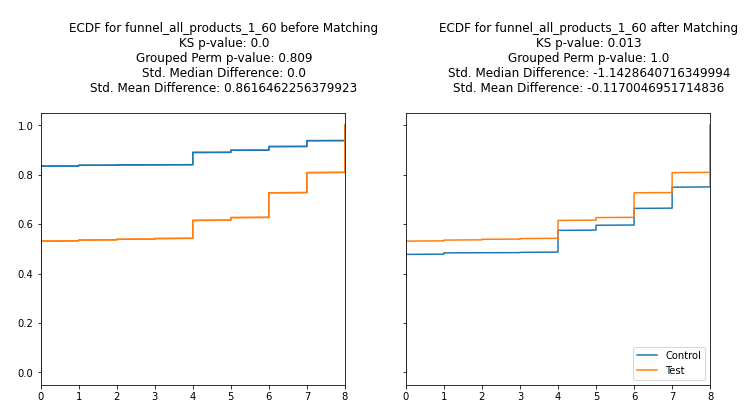

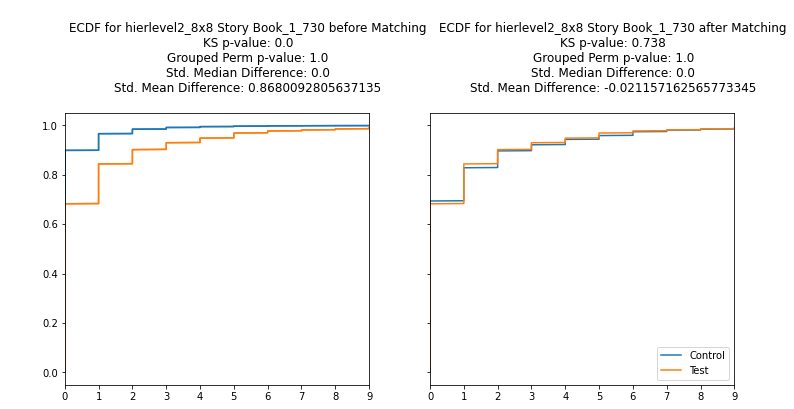

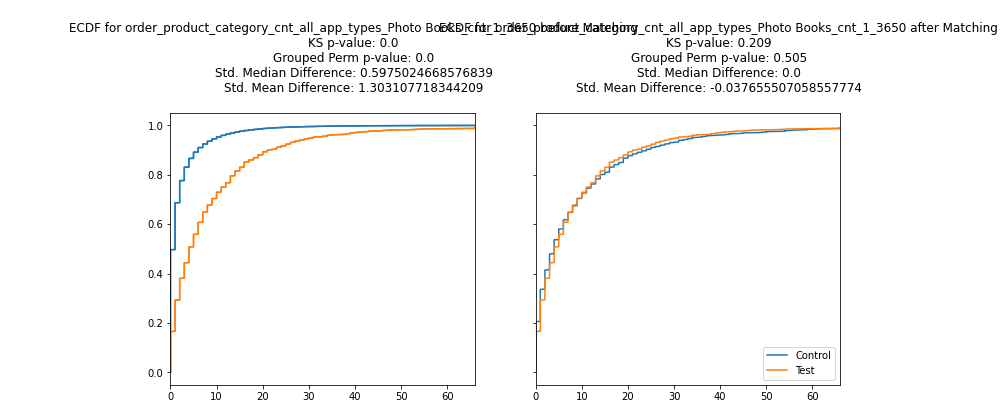

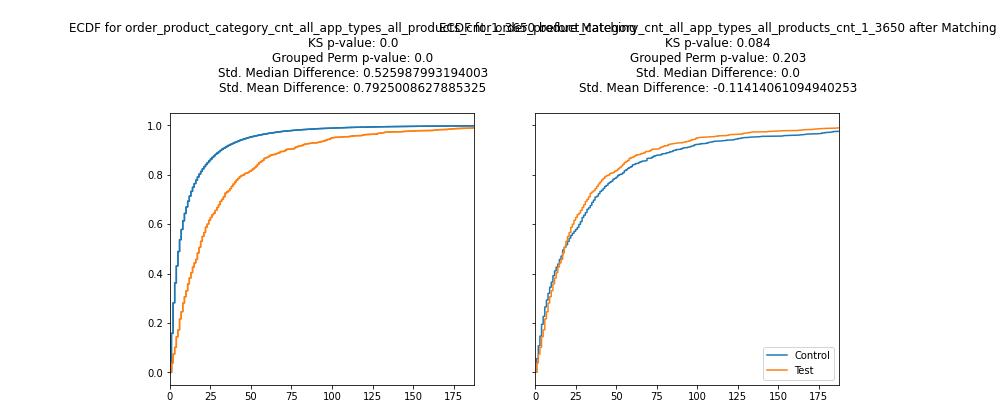

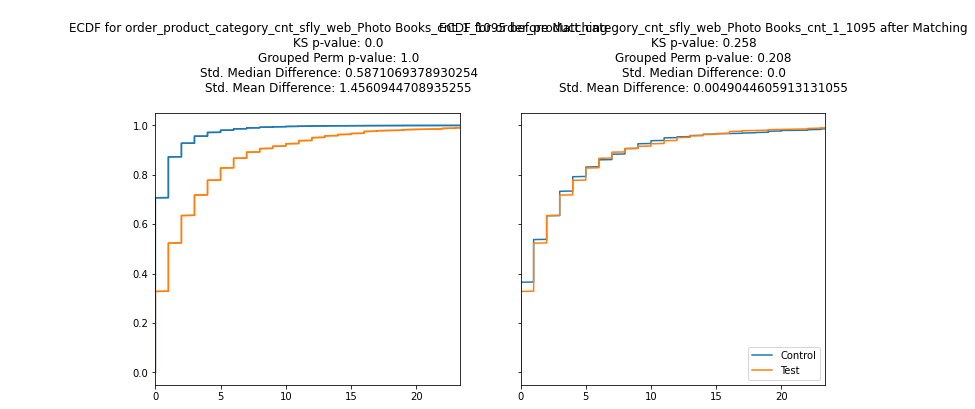

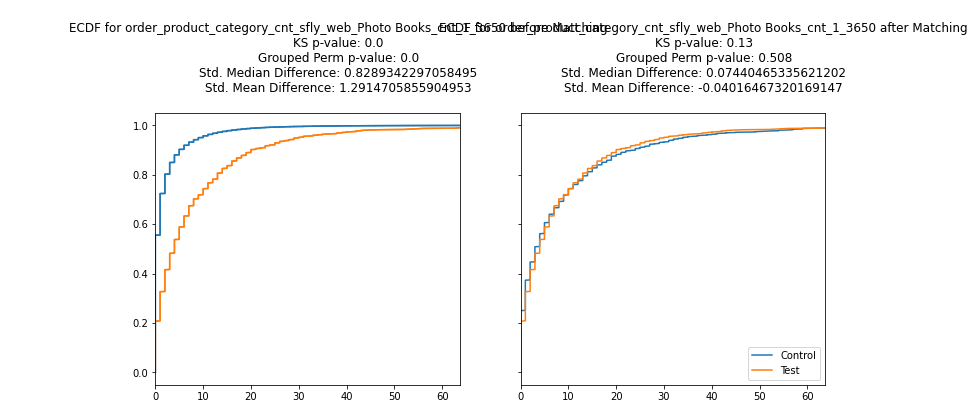

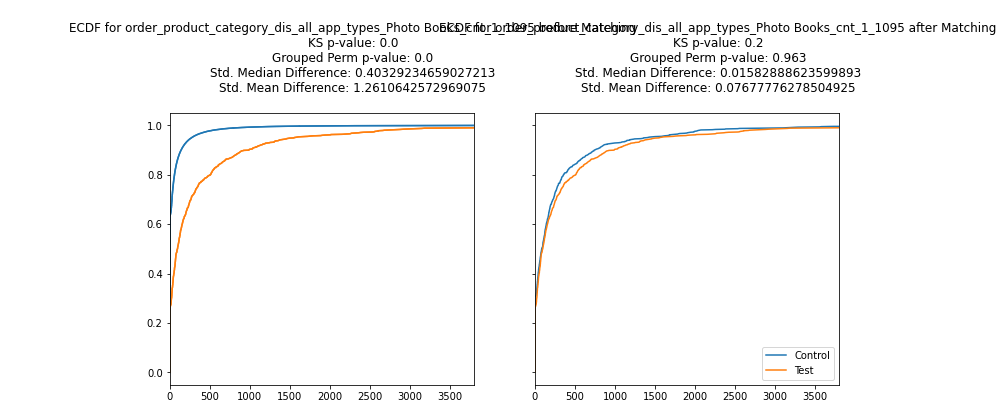

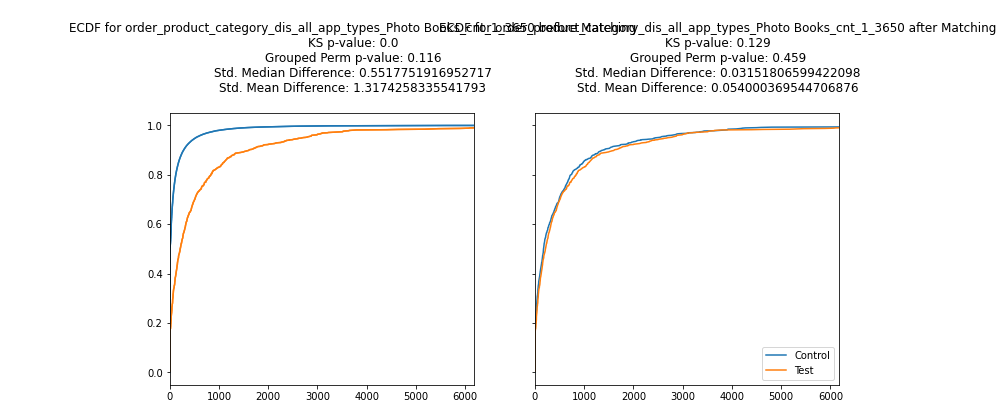

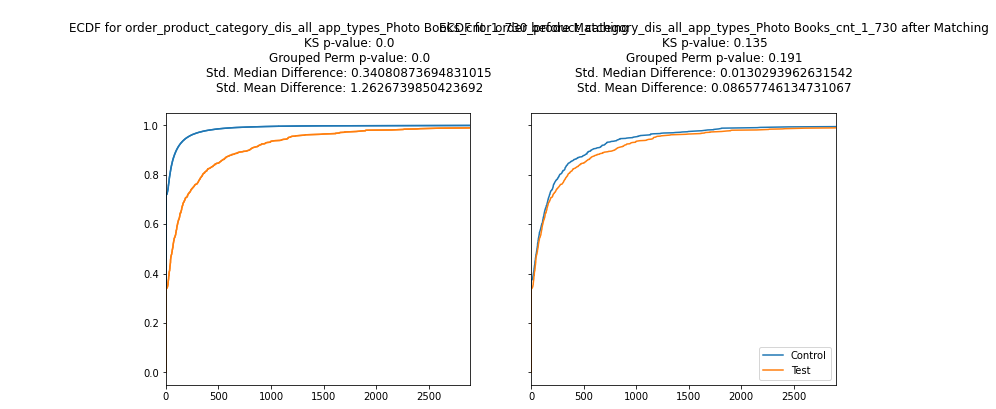

In [146]:
# Comparing the before and after PSM
cc = m.compare_continuous(return_table=True,)
